# 8.2.3 Estimación Robusta de la Covarianza

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
# import matplotlib.font_manager
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet

import warnings
warnings.filterwarnings("ignore")

Link: https://youtu.be/VnHwn6WqEIE?si=4hifVR78CFynNp-O

Links: https://scikit-learn.org/stable/auto_examples/covariance/plot_robust_vs_empirical_covariance.html

La función EmpiricalCovariance() realiza el estimador de máxima verosimilitud de la matriz de covarianzas de los datos, suponiendo que hay una cantidad suficientemente grande de patrones respecto a la cantidad de características. Este estimador se ve fuertemente afectado por la presencia de outliers en los datos.

El estimador robusto busca seleccionar una porción de buenas observaciones que no contienen outliers para realizar la estimación empírica de la covarianza; posteriormente, la matriz es re-escalada con el fin de compensar el paso de filtrado de las observaciones originales.

Para ello, el estimador busca

$$ \frac{1}{2}(n_{samples} − n_{features} − 1) $$

muestras que tienen el menor valor del determinante.

La metodología implementada en sklearn se llama Minimum Covariance Determinant.

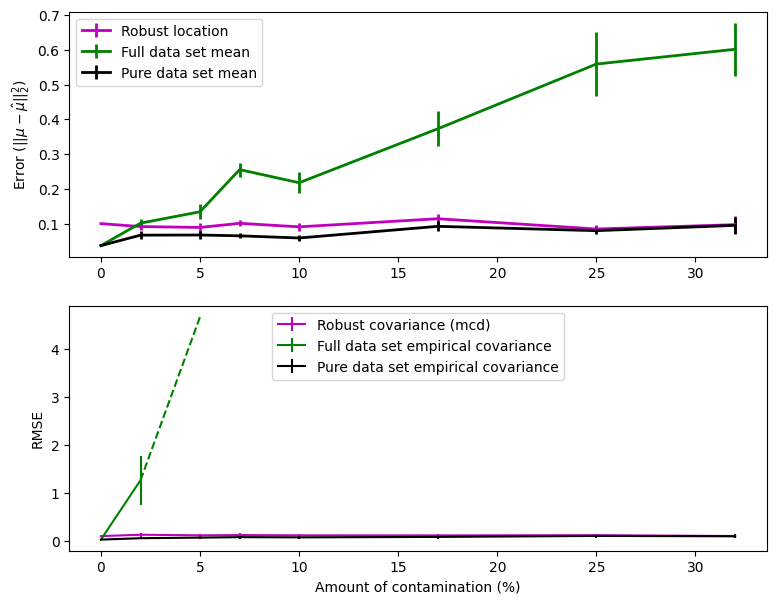

In [3]:
n_samples = 80
n_features = 5
repeat = 20

range_n_outliers = np.array([0, 2, 5, 7, 10, 17, 25, 32]).astype(int)

#
# Error de la estimación sobre todos los datos
#
err_loc_emp_full = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_full = np.zeros((range_n_outliers.size, repeat))

#
# Error de la estimación sobre los inliers
#
err_loc_emp_pure = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_pure = np.zeros((range_n_outliers.size, repeat))

#
# Error obtenido usando MCD
#
err_loc_mcd = np.zeros((range_n_outliers.size, repeat))
err_cov_mcd = np.zeros((range_n_outliers.size, repeat))

# computation
for i, n_outliers in enumerate(range_n_outliers):
    for j in range(repeat):

        rng = np.random.RandomState(i * j)

        #
        # Muestra aleatoria de datos con media cero y varianza
        # unitaria. Es decir, cada patrón proviene de una
        # distribución normal multivariada con media cero y
        # matriz de covarianzas igual a la matriz identidad
        #
        X = rng.randn(n_samples, n_features)

        #
        # Selecciona 'n_outliers' puntos de la muestra
        # aleatoria de datos
        #
        outliers_index = rng.permutation(n_samples)[:n_outliers]

        #
        # Genera una matriz de +/- 5 para contaminar la
        # muestra de datos original
        #
        outliers_offset = 10.0 * (
            np.random.randint(2, size=(n_outliers, n_features)) - 0.5
        )
        X[outliers_index] += outliers_offset

        #
        # Marca cada patrón de la muestra de datos como inlier/outlier
        #
        inliers_mask = np.ones(n_samples).astype(bool)
        inliers_mask[outliers_index] = False

        #
        # Error cuadrático al estimar la media. La muestra
        # de datos tiene media cero. Este error es computado sobre
        # todos los datos (inliers + outliers)
        #
        err_loc_emp_full[i, j] = np.sum(X.mean(0) ** 2)

        #
        # Se computa el MSE entre la matriz estimada sobre la totalidad
        # de los datos (inliers + outliers) y la matriz identidad.
        #
        estimator = EmpiricalCovariance(
            # ---------------------------------------------
            # If True, data are not centered before computation.
            assume_centered=False,
        )

        #
        # El objeto cuenta con los siguientes atributos
        #   location_
        #   covariance_
        #   precision_ : estimated pseudo-inverse matrix
        #
        err_cov_emp_full[i, j] = estimator.fit(X).error_norm(np.eye(n_features))

        #
        # Se computa la media y la matriz de covarianzas usando
        # unicamente los inliers
        #
        pure_X = X[inliers_mask]
        pure_location = pure_X.mean(0)
        pure_emp_cov = EmpiricalCovariance().fit(pure_X)

        #
        # Errores sobre los inliers
        #
        err_loc_emp_pure[i, j] = np.sum(pure_location ** 2)
        err_cov_emp_pure[i, j] = pure_emp_cov.error_norm(np.eye(n_features))

        #
        # Estimación usando Minimum Covariance Determinant
        #
        mcd = MinCovDet().fit(X)
        err_loc_mcd[i, j] = np.sum(mcd.location_ ** 2)
        err_cov_mcd[i, j] = mcd.error_norm(np.eye(n_features))


plt.figure(figsize=(9, 7))
plt.subplot(2, 1, 1)

plt.errorbar(
    range_n_outliers,
    err_loc_mcd.mean(1),
    yerr=err_loc_mcd.std(1) / np.sqrt(repeat),
    label="Robust location",
    lw=2,
    color="m",
)

plt.errorbar(
    range_n_outliers,
    err_loc_emp_full.mean(1),
    yerr=err_loc_emp_full.std(1) / np.sqrt(repeat),
    label="Full data set mean",
    lw=2,
    color="green",
)

plt.errorbar(
    range_n_outliers,
    err_loc_emp_pure.mean(1),
    yerr=err_loc_emp_pure.std(1) / np.sqrt(repeat),
    label="Pure data set mean",
    lw=2,
    color="black",
)

plt.ylabel(r"Error ($||\mu - \hat{\mu}||_2^2$)")
plt.legend(loc="upper left")

plt.subplot(2, 1, 2)
x_size = range_n_outliers.size

plt.errorbar(
    range_n_outliers,
    err_cov_mcd.mean(1),
    yerr=err_cov_mcd.std(1),
    label="Robust covariance (mcd)",
    color="m",
)

plt.errorbar(
    range_n_outliers[: (x_size // 5 + 1)],
    err_cov_emp_full.mean(1)[: (x_size // 5 + 1)],
    yerr=err_cov_emp_full.std(1)[: (x_size // 5 + 1)],
    label="Full data set empirical covariance",
    color="green",
)

plt.plot(
    range_n_outliers[(x_size // 5) : (x_size // 2 - 1)],
    err_cov_emp_full.mean(1)[(x_size // 5) : (x_size // 2 - 1)],
    color="green",
    ls="--",
)
plt.errorbar(
    range_n_outliers,
    err_cov_emp_pure.mean(1),
    yerr=err_cov_emp_pure.std(1),
    label="Pure data set empirical covariance",
    color="black",
)

plt.xlabel("Amount of contamination (%)")
plt.ylabel("RMSE")
plt.legend(loc="upper center")

plt.show()

In [4]:
print('ok_')

ok_
